---
>「人は手ではなく脳で絵を描く。」
>
> ミケランジェロ
---

# Text2imageのパーソナライズ化

強力なText-to-imageモデルではあるが、例えば「自分の飼っている猫を入れた画像を生成したい」といった、特定のユニークな概念の画像を生成したり、その外観を変更したり、新しい役割や新規のシーンに合成したりすることはできれば、さらに利用価値が高まる

ここでは、オブジェクトやスタイルなど、利用者が提供した3-5枚の画像のみ使い、構築済みのテキスト-画像モデル変換モデルにおける潜在空間に新しい「言葉」を使って表現できるように学習させる

- つまり、新しいスタイルとしてのオブジェクトを含む画像を提示し、そこにあるオブジェクトに新たな「名前」を与えておくことで、その「名前」を用いて画像を生成することで、そのオブジェクトを含む画像を生成させる

- この「言葉」は、自然言語文として構成することができるため、直感的な方法で所望の画像を生成させることができる


学習および生成には次のような注意点がある

- 初期化語はオブジェクトを説明する単語、例えば、toy、picture、scruptureなどとすること
  - 入力が単語出ない場合は、再入力となる
- ここではepochを5千としているが、通常はより速く収束する
- エンベッディングと出力画像はlogディレクトリに保存される
- 概念を表すプレースホルダーの変更（デフォルトは "*"）、学習反復の最大回数の変更、チェックポイントの保存頻度の変更など、その他のオプションは configs/latent-diffusion/txt2img-1p4B-finetune.yaml を参照すること
- トレーニングセットの画像はすべて正立させておくこと
  - 特に、スマートフォンで撮影した画像は、画像自体が倒立しており、表示の際に正立させる場合も多く、このままでは利用できない
- プロンプトに "a photo of "を追加すると、対象となる生成画像の一貫性がより良くなるので、利用するとよい
- 結果は乱数のシードの影響を受けるため、結果に満足できない場合は、新しいシードで生成するとよい


生成結果の例

左の画像にあるオブジェクトに`S*`という名前を付け、これを用いて生成させた例を示す
- この例をみれば、何がしたいのかがわかるであろう

![](http://class.west.sd.keio.ac.jp/dataai/text/teaser.jpg)

![](http://class.west.sd.keio.ac.jp/dataai/text/diffusionsamples.jpg)

![](http://class.west.sd.keio.ac.jp/dataai/text/diffusionstyle.jpg)

## 関連用語整理

### 転移学習

解いた設問の解法を別の設問に応用する場合において、**データセットの量が不十分**なうえで、精度の高いモデルを獲得する手法

既存の学習済みモデルを別の目的のモデルとして利用するために、ネットワークの一部を変更したりしつつ、学習済みパラメータをもとに、新たに追加したモデルのデータのみ学習させる

### ファインチューニング

新たに学習するデータセットが多いケースでは、転移学習をそのまま行うとかえって時間がかかる可能性があるため、一度解いた設問の解法を別の設問のために微調整する手法

**データセットの量が十分**にあることが前提としてあり、モデル全体のデータを再学習することで、汎化性能をより向上させる

### 蒸留

学習済みモデルを使用して、より軽量なモデルを生み出す手法

学習済みモデルを教師モデルとして、その出力を生徒モデルの学習に利用する
- 教師モデルから生徒モデル間の損失を「ソフトターゲットロス」、生徒モデルの学習データの正解ラベルを「ハードターゲット」、その損失を「ハードターゲットロス」と呼ぶ
- ラベル付きデータを利用する場合はこれら2種類のターゲットロスを用い、ラベルなしのデータを利用する場合はソフトターゲットロスのみを用いて学習を行う

### Few-shot Learning（フューショット学習）

画像生成モデルやChatGPTなどの巨大言語モデルにおいて、ファインチューニングすることなく、少数の例文を文脈の中で提示するだけで、さまざまなタスクを達成できるように、少量のデータを与えることで求める結果を得る手法

言語モデルのパラメータは更新せず、少数の例文を文脈の中でデモンストレーションとして提示することで、さまざまなタスクを解決する能力を持たせることができる

特に、例文・見本が1つだけの場合「ワンショット学習（One-shot learning）」、例文がない場合「ゼロショット学習（Zero-shot Learning）」と呼ぶ

これらについては、ChatGPTでより詳しく触れる

### 事前学習

関連する新たな目的に利用するため、あらかじめ大量のデータセットで学習させたモデルを構築すること

この事前学習モデルは、新たなタスクへの転移学習やファインチューニングの基盤モデルとなる

### マルチタスク学習

複数の関連するタスクを同時に学習する手法



ここでは、数枚の画像を用いて再学習してモデルパラメータを更新させるため、few-shotファインチューニングといえる

では早速ためしてみよう

Colabでは全体の実行に、およそ30分程度必要である

## 環境セットアップ

ライブラリをインストール

In [ ]:
!pip install -qq git+https://github.com/huggingface/diffusers.git accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

改めてHugging Faceログインを行う
- 先に用いた登録済トークンを入力する
- ここでは、既に入力されていることを前提とし、コメントアウトしている

In [ ]:
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

ライブラリをインポートする

In [ ]:
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset
import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
#from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import bitsandbytes as bnb

画像表示関数を定義する

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## 学習済モデル・追加学習画像のセットアップと学習

事前学習済みモデルを登録する

特に修正の必要はないが、他のモデルを試すこともできる



In [ ]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

スタイル画像を指定する
- 5枚程度でよい

In [ ]:
urls = [
    'https://1.bp.blogspot.com/-JLT7FAbMiF4/X3hGHAgEHjI/AAAAAAABboc/OWpiTz5HLHg9A1b5tK7RVz1orj2H0XKvwCNcBGAsYHQ/s250/penlight_man01_blue.png',
    'https://1.bp.blogspot.com/-qrkLCElBrZU/X3hGIGBcv0I/AAAAAAABbos/uumBDo0U7TgnTwvhbqMWEWSlqeA3kuNVACNcBGAsYHQ/s250/penlight_man05_orange.png',
    'https://1.bp.blogspot.com/-TPcG8H-94Q8/XAnwX_0l2FI/AAAAAAABQw4/wJI0CD-SxO4UWBm8YVegxlls031mKKqzgCLcBGAs/s330/stand_naname1_boy.png',
    'https://4.bp.blogspot.com/-ld3QWamGpWI/XAnwYQ4RPeI/AAAAAAABQw8/AcQhuWaS_CAFHfINOJDm3wxmFG57AhmFgCLcBGAs/s380/stand_naname2_school_boy.png',
    'https://1.bp.blogspot.com/-LgVrdZ34XRM/XAnwY68nMrI/AAAAAAABQxA/P71YbDy3z3YCWiX9rLRsPQPw0iUzevxGwCLcBGAs/s400/stand_naname3_man.png',
    'https://1.bp.blogspot.com/-598mkkGFaD8/XAnwZDh48DI/AAAAAAABQxE/y-rIs9aaPQMVaYIuM_LaY2Q1HJojNIT0wCLcBGAs/s400/stand_naname4_businessman.png'
          ]

指定したスタイル画像を確認する
- ここでは、いらすとやの画像を用いて、いらすとや風の画像を自由に生成させよう

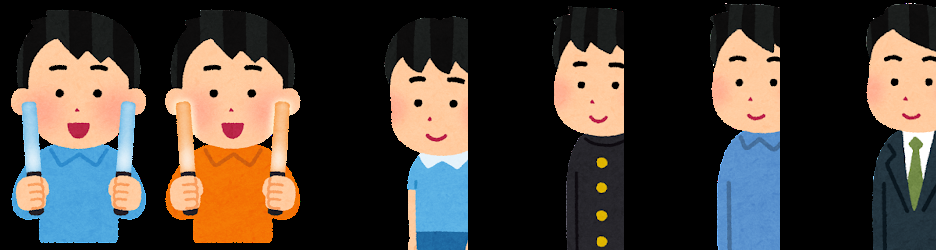

In [ ]:
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)

[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

学習の準備を行う

- まず、オブジェクトや画風の説明を行う
- ここをどのように与えるかで最終生成画像の質が変わる
- 試しに独自の画像をしているする場合は、ここで指定している`instance_prompt`および`prior_preservation_class_prompt`を参考にして各自指定すること

In [ ]:
# オブジェクト、画風の説明
instance_prompt = " an illustration of sks boy" #@param {type:"string"}

# コンセプトクラスの指定、画質が向上
prior_preservation = False #@param {type:"boolean"}
prior_preservation_class_prompt = " an illustration of a boy" #@param {type:"string"}

num_class_images = 12
sample_batch_size = 2
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt

事前保存のための高度な設定を行う
- 特に修正の必要はない

In [ ]:
num_class_images = 12
sample_batch_size = 2
prior_loss_weight = 1

prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder

DreamBoothデータセットとプロンプトデータセットのクラスを定義する

In [ ]:
from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

コンセプトクラスが指定されている場合、その設定を行う

In [ ]:
import gc
if(prior_preservation):
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, use_auth_token=True, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            with torch.autocast("cuda"):
                images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

In [ ]:
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", use_auth_token=True
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae", use_auth_token=True
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", use_auth_token=True
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    use_auth_token=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


各種ハイパーパラメータを指定する
- ここで乱数のシードも変更できる

In [ ]:
from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=512,
    center_crop=True,
    instance_data_dir=save_path,
    instance_prompt=instance_prompt,
    learning_rate=5e-06,
    max_train_steps=450,
    train_batch_size=1,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="no", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation,
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder,
    class_prompt=prior_preservation_class_prompt,
    num_class_images=num_class_images,
    output_dir="dreambooth-concept",
)

学習用の関数を定義する

In [ ]:
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
    )

    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    noise, noise_prior = torch.chunk(noise, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior, noise_prior, reduction="none").mean([1, 2, 3]).mean()

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(args.output_dir)

## 訓練

実際に訓練を行う

30分弱程度必要である

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, num_processes=1, args=(text_encoder, vae, unet))
with torch.no_grad():
    torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/450 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:128: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.21.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have 

## 推論

画像を生成させる

同じ学習済みモデルを用いて再度生成する場合は、この下のセルを再実行すること

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
        args.output_dir,
        torch_dtype=torch.float16,
    ).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

オブジェクトに「いらすとや」の画像を用いたので、いらすとや風の画像を生成できるようになる

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

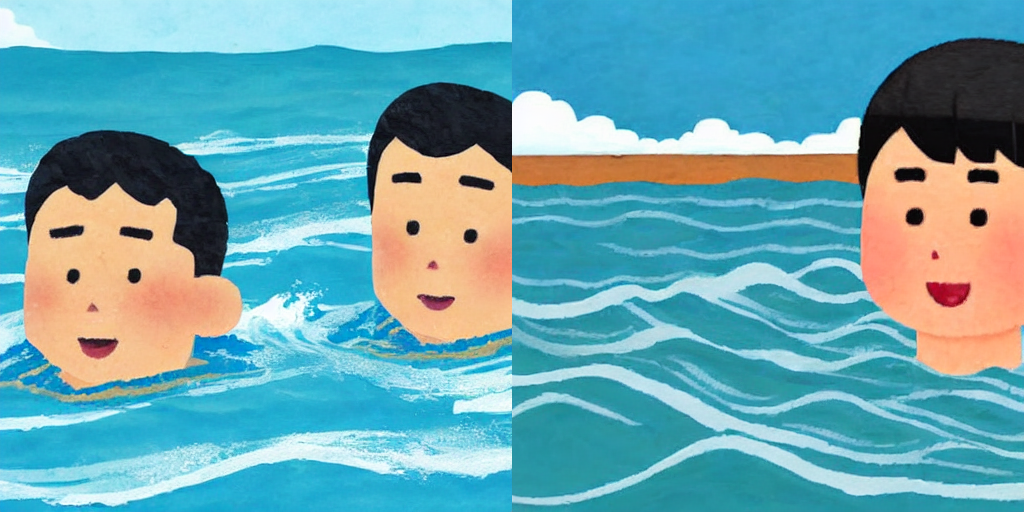

In [ ]:
from torch import autocast
prompt = " an real illustration of sks boy swimming sea" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    with autocast("cuda"):
        images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
        all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

# 課題

Dearmboothにより、サンプル画像を準備し、そのサンプル画像をもとに画像を生成してみよう